In [12]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from Bio.Blast import NCBIWWW
import seaborn as sns
from matplotlib import gridspec
from itertools import combinations
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# function to create colour dictionaries from a colour map and a list of items
def colourDict(data,cmap=mpl.cm.viridis,sort=False):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name. If sort = False, the function takes an ordered list of unique elements
    """
    cmap=cmap # default viridis
    data_unique=data if sort == False else list(set(data)) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

In [2]:
names = ['p1_p2','p1_p3','p1_p4','p2_p3','p2_p4','p3_p4']
fst = pd.read_csv('./pairwise_snp_fst_mincov10_minmaf005_block10_20221201.txt', sep ='\t', names = ['CHROM']+names, skiprows = [0])
fst

CHROM     p1_p2     p1_p3     p1_p4     p2_p3     p2_p4     p3_p4
0          1 -0.062072  0.007914  0.015681  0.001491  0.007808       NaN
1          2       NaN  0.829299  1.000000  0.788424  0.941451  0.101738
2          3       NaN  0.736624  1.000000  0.706262  0.944632  0.229578
3          4       NaN  0.829299  1.000000  0.793879  0.944632  0.115139
4          5       NaN  0.823276  1.000000  0.748042  0.931212  0.115139
...      ...       ...       ...       ...       ...       ...       ...
20639  20640 -0.057678 -0.004680 -0.004137 -0.049373 -0.046310 -0.062996
20640  20641 -0.012739  0.605879  0.535852  0.346602  0.280634       NaN
20641  20642  0.118426  0.178884  0.229038  0.432226  0.481635       NaN
20642  20643 -0.044154  0.696837  0.717818  0.498034  0.522097       NaN
20643  20644  0.085949  0.767292  0.872990  0.948449  1.000000       NaN

[20644 rows x 7 columns]

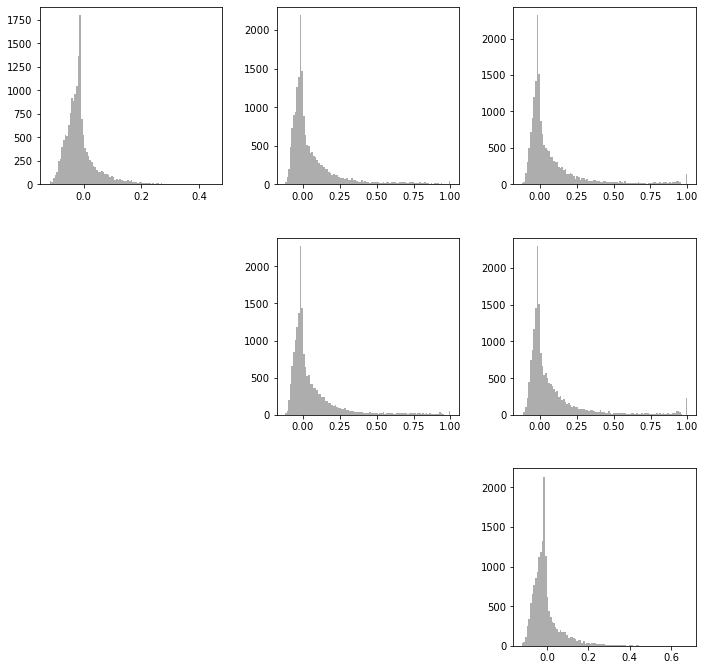

In [3]:
# we expect to find outliers in p1_p3, p2_p4, p1_p4, and p2_p3 that do not appear as outliers in p1_p2 or p3_p4
# we also need to understand the distribution of Fst values in each comparison

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.3,wspace=0.3)
spinescol='#999999'

pools = ['p1','p2','p3','p4']
names = {'p1':'macall',
         'p2':'macsym',
         'p3':'acasym',
         'p4':'acaall'}

plt.title('Distribution of Fst values between pools')

for x,y in combinations([i for i,x in enumerate(pools)],2):
    ax=plt.subplot(G[x,y])
    data975 = fst['%s_%s'%(pools[x],pools[y])].quantile(0.9)
    try:
        temp = fst[fst['%s_%s'%(pools[x],pools[y])] <= data975].copy(deep = True)
        outlier = fst[fst['%s_%s'%(pools[x],pools[y])] > data975].copy(deep = True)
        
        ax.hist(fst['%s_%s'%(pools[x],pools[y])], bins = 100, color = '#adadad')      
#         ax.hist(temp['%s_%s'%(pools[x],pools[y])], bins = 90, color = '#adadad')
#         ax.hist(outlier['%s_%s'%(pools[x],pools[y])], bins = 90, facecolor = '#faac02', edgecolor = '#faac02', lw = 1.5)
        
        ax.vlines(x = [data025, data975], ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = '#bababa', lw = 1)
        
        ax.set_xlabel('%s vs. %s'%(names[pools[x]],names[pools[y]]), fontsize = 14, color = spinescol)
        
        [ax.spines[loc].set_visible(False) for loc in ['right','top']]
        plt.yticks(fontsize = 12, color = spinescol); plt.xticks(fontsize = 12, color = spinescol)
        
        if len(outlier) > 1:
            ax1 = inset_axes(ax, width = '50%', height = '50%', loc = 1, borderpad = 0.1)
            ax1.hist(outlier['%s_%s'%(pools[x],pools[y])], bins = 20, facecolor = '#faac02', edgecolor = '#faac02', lw = 1)
            ax1.vlines(x = 0.9, ymin = ax1.get_ylim()[0], ymax = ax1.get_ylim()[1], color = '#bababa', lw = 1)
            [ax1.spines[loc].set_visible(False) for loc in ['right','top']]
            plt.yticks(fontsize = 10, color = spinescol); plt.xticks(fontsize = 10, color = spinescol)            

    except:
        pass
    

plt.show()

In [45]:
def KDEplot(data, size, ax, color = '#e41c5e', mute = '#bababa'):
    """
    where data is a pandas dataframe, single column
    size of the distribution range, two-tailed, that is not significant if overlaps 0
    """
    # gathers values, to floats, drops nans
    size = size
    ax = ax
    color = color
    values = data.dropna().astype('float').values
    
    # gets boundaries
    data025 = data.quantile(0+(1-size)/2)
    data975 = data.quantile(1-(1-size)/2)
    
    # within range size
    kde = gaussian_kde(values)
    x_grid = np.linspace(min(values),max(values),100)
    ax.fill_between(x_grid, kde(x_grid),
                    alpha = 1, edgecolor = 'none',
                    facecolor = color, zorder = 1)
    ax.fill_between(x_grid, kde(x_grid),
                    where = [data025 <= x <= data975 for x in x_grid],
                    alpha = 1, edgecolor = mute,
                    facecolor = mute, zorder = 2, lw = 0.5)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.yticks(fontsize = 12, color = spinescol); plt.xticks(fontsize = 12, color = spinescol)
    return ax

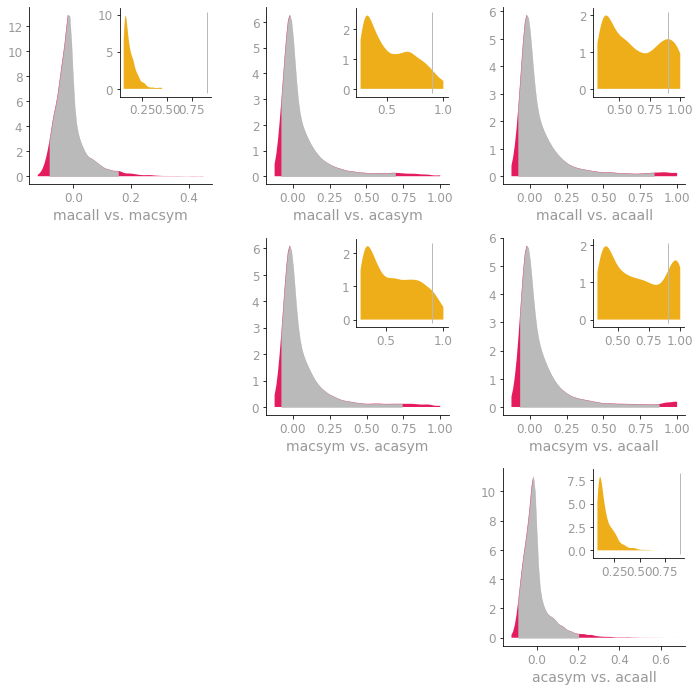

In [50]:
# we expect to find outliers in p1_p3, p2_p4, p1_p4, and p2_p3 that do not appear as outliers in p1_p2 or p3_p4
# we also need to understand the distribution of Fst values in each comparison

plt.figure(figsize=(4*4,4*4),facecolor='w')
G = gridspec.GridSpec(4,4,hspace=0.3,wspace=0.3)
spinescol='#999999'

pools = ['p1','p2','p3','p4']
names = {'p1':'macall',
         'p2':'macsym',
         'p3':'acasym',
         'p4':'acaall'}

plt.title('Distribution of Fst values between pools')

for x,y in combinations([i for i,x in enumerate(pools)],2):
    ax=plt.subplot(G[x,y])
    data975 = fst['%s_%s'%(pools[x],pools[y])].quantile(0.9)

    KDEplot(fst['%s_%s'%(pools[x],pools[y])], 0.95, ax = ax, color = '#e41c5e')
    ax.set_xlabel('%s vs. %s'%(names[pools[x]],names[pools[y]]), fontsize = 14, color = spinescol)
#     ax.vlines(x = data975, ymin = ax.get_ylim()[0], ymax = ax.get_ylim()[1], color = '#bababa', lw = 1)
    
#     data975 = fst['%s_%s'%(pools[x],pools[y])].quantile(0.9)
    outlier = fst[fst['%s_%s'%(pools[x],pools[y])] > data975].copy(deep = True)
    
    if len(outlier) > 1:
        ax1 = inset_axes(ax, width = '50%', height = '50%', loc = 1, borderpad = 0.1)
        KDEplot(outlier['%s_%s'%(pools[x],pools[y])], 0, ax = ax1, color = '#edae1a')
        ax.set_xlabel('%s vs. %s'%(names[pools[x]],names[pools[y]]), fontsize = 14, color = spinescol)
        ax1.vlines(x = 0.9, ymin = ax1.get_ylim()[0], ymax = ax1.get_ylim()[1], color = '#bababa', lw = 1)

plt.show()

In [126]:
# if we only look at outlier loci, definint them as SNPs with Fst >= 0.9
# then all those appear in cross-morphotypes and not within morphotyes
fst.describe()

CHROM         p1_p2         p1_p3         p1_p4         p2_p3  \
count  20644.000000  16316.000000  18359.000000  18575.000000  18334.000000   
mean   10322.500000     -0.010877      0.066329      0.087288      0.072505   
std     5959.553814      0.059053      0.184456      0.212085      0.193334   
min        1.000000     -0.123752     -0.122828     -0.123321     -0.123258   
25%     5161.750000     -0.044023     -0.033482     -0.026912     -0.031854   
50%    10322.500000     -0.019554     -0.004535      0.002491     -0.002885   
75%    15483.250000      0.001107      0.090431      0.110003      0.096611   
max    20644.000000      0.449848      1.000000      1.000000      1.000000   

              p2_p4         p3_p4  
count  18639.000000  16249.000000  
mean       0.091911     -0.004233  
std        0.218495      0.074049  
min       -0.123752     -0.122828  
25%       -0.025752     -0.046532  
50%        0.005189     -0.018705  
75%        0.113280      0.008013  
max        1.000000      0.679754

In [127]:
# we need to get lists of the indices of outlier loci for each comparison
# we also want to focus on SNPs found in all four cross morphotype comparisons
# p1_p3, p1_p4, p2_p3, p2_p4

outliers = {}
for x,y in combinations([i for i,x in enumerate(pools)],2):
    outlier = fst[fst['%s_%s'%(pools[x],pools[y])] >= 0.9].copy(deep = True)
    if len(outlier) > 1:
        outliers['%s_%s'%(pools[x],pools[y])] = list(outlier['%s_%s'%(pools[x],pools[y])].index)
                
        print('%s_%s'%(pools[x],pools[y]), 'Num. of outlier loci: ',len(outlier))
        print(outlier['%s_%s'%(pools[x],pools[y])].describe())
        print('\n')

p1_p3 Num. of outlier loci:  99
count    99.000000
mean      0.951612
std       0.039445
min       0.902466
25%       0.915727
50%       0.936568
75%       1.000000
max       1.000000
Name: p1_p3, dtype: float64


p1_p4 Num. of outlier loci:  322
count    322.000000
mean       0.961470
std        0.036890
min        0.900138
25%        0.927359
50%        0.950270
75%        1.000000
max        1.000000
Name: p1_p4, dtype: float64


p2_p3 Num. of outlier loci:  149
count    149.000000
mean       0.949938
std        0.036778
min        0.900672
25%        0.921800
50%        0.934896
75%        1.000000
max        1.000000
Name: p2_p3, dtype: float64


p2_p4 Num. of outlier loci:  447
count    447.000000
mean       0.967366
std        0.035241
min        0.902266
25%        0.933786
50%        1.000000
75%        1.000000
max        1.000000
Name: p2_p4, dtype: float64




In [138]:
from collections import Counter

selected_outliers=[]
for key,value in Counter(sorted(sum(outliers.values(),[]))).items():
    if value == 4:
        print(key,value)
        selected_outliers.append(key)
print('Number of selected outlier loci: ',len(selected_outliers))

963 4
1356 4
1814 4
1884 4
1885 4
2392 4
2393 4
2787 4
2788 4
2789 4
2989 4
3072 4
3650 4
5630 4
6671 4
6736 4
6737 4
6738 4
6883 4
6892 4
7294 4
7295 4
7296 4
7297 4
7298 4
7923 4
7937 4
8422 4
8423 4
8424 4
10237 4
10238 4
10239 4
10240 4
10831 4
10832 4
10833 4
10834 4
11112 4
11113 4
11789 4
12561 4
12562 4
12563 4
13751 4
14325 4
14566 4
14567 4
15175 4
16306 4
17050 4
17051 4
17052 4
17053 4
17054 4
17362 4
18955 4
19258 4
19315 4
19698 4
20251 4
Number of selected outlier loci:  61


In [137]:
# we need fo figure out which chromosomes the SNPs belong to.
# we can use the snp info table generated when uploading the vcf file to poolfstat
# always make sure the number of SNPs uploaded (min and max filter values) coincide with the filters applied to Fst estimation

snpinfo = pd.read_csv('./snp_info_mincov10_minmaf005_block10_20221201.txt', sep = '\t')
snpinfo

Chromosome  Position RefAllele AltAllele
1                 NC_025994.1_RagTag_RagTag  30374349         C         G
2                 NC_025994.1_RagTag_RagTag  30374353         C         T
3                 NC_025994.1_RagTag_RagTag  30374363         C         T
4                 NC_025994.1_RagTag_RagTag  30374367         C         T
5                 NC_025994.1_RagTag_RagTag  30374382         A         G
...                                     ...       ...       ...       ...
20640  NODE_9830_length_11554_cov_20.428037     11547         C         T
20641  NODE_9830_length_11554_cov_20.428037     11548         C         T
20642  NODE_9850_length_11543_cov_23.292044     11518         G         A
20643  NODE_9967_length_11475_cov_21.076270     11437         G         T
20644  NODE_9995_length_11456_cov_15.752390     11378         T         A

[20644 rows x 4 columns]

In [141]:
# add a column indicating if the SNP is a selected outline or not

snpinfo['outlier'] = ''

for index,row in enumerate(snpinfo.itertuples()):
    if index in selected_outliers:
        snpinfo.loc[index,'outlier'] = 'selected'
#         print(index,row)
snpinfo

Chromosome  Position RefAllele AltAllele  \
1                 NC_025994.1_RagTag_RagTag  30374349         C         G   
2                 NC_025994.1_RagTag_RagTag  30374353         C         T   
3                 NC_025994.1_RagTag_RagTag  30374363         C         T   
4                 NC_025994.1_RagTag_RagTag  30374367         C         T   
5                 NC_025994.1_RagTag_RagTag  30374382         A         G   
...                                     ...       ...       ...       ...   
20640  NODE_9830_length_11554_cov_20.428037     11547         C         T   
20641  NODE_9830_length_11554_cov_20.428037     11548         C         T   
20642  NODE_9850_length_11543_cov_23.292044     11518         G         A   
20643  NODE_9967_length_11475_cov_21.076270     11437         G         T   
20644  NODE_9995_length_11456_cov_15.752390     11378         T         A   

      outlier  
1              
2              
3              
4              
5              
...       ...  
20640          
20641          
20642          
20643          
20644          

[20644 rows x 5 columns]

In [142]:
snpinfo[snpinfo['outlier'] == 'selected']

Chromosome  Position RefAllele AltAllele  \
963            NW_011551488.1_RagTag_RagTag     17489         A         G   
1356           NW_011551989.1_RagTag_RagTag     64168         C         T   
1814           NW_011552785.1_RagTag_RagTag      5126         G         A   
1884           NW_011552973.1_RagTag_RagTag     27259         A         G   
1885           NW_011553003.1_RagTag_RagTag     20099         G         A   
...                                     ...       ...       ...       ...   
18955  NODE_33153_length_5093_cov_27.094482      5079         G         A   
19258  NODE_33397_length_5060_cov_27.626573      4971         G         A   
19315  NODE_33433_length_5055_cov_11.168000      5006         G         A   
19698  NODE_33818_length_5006_cov_25.112301      4956         C         T   
20251  NODE_7557_length_13127_cov_25.211750     13067         C         A   

        outlier  
963    selected  
1356   selected  
1814   selected  
1884   selected  
1885   selected  
...         ...  
18955  selected  
19258  selected  
19315  selected  
19698  selected  
20251  selected  

[61 rows x 5 columns]

In [4]:
# get a list of the contigs
# we can grep the contig from the reference
# and around 100 nucleotides before and after the position of the sequence to blast the sequence
snpinfo[snpinfo['outlier'] == 'selected'][['Chromosome','Position']].to_csv('./selected_loci_ref_20221202.txt', sep = '\t')

NameError: name 'snpinfo' is not defined

In [182]:
%%bash

while read -r line;
do
    CHROM=$(echo "$line" | cut -f 2)
    POS=$(echo "$line" | cut -f 3)
    grep -A1 "$CHROM" ../ref/k55hyb_GUR2/ragtag.scaffold.fasta >> selected_contigs.fasta
done < selected_loci_ref_20221202.txt

In [3]:
# find sequences up and downstream from the SNPs in the reference sequence


toblast={}

for line in open('./selected_contigs.fasta', 'r'):
#     print(line)
    if '>' in line:
        chrom = line.strip('>').strip('\n')
        # replaces poss empty list with list of positions
        poss = list(snpinfo[snpinfo['Chromosome'] == chrom]['Position'].values)
        print(chrom, 'pos: ', poss)
        
    else:
        print(poss) # should be the one from the contig in the line before
        # here iterates through the different positions
        for pos in poss:
            toblast['%s_%s-%s'%(chrom,pos,1000)] = line[pos-1000:pos].strip('\n')
            toblast['%s_%s+%s'%(chrom,pos,1000)] = line[:pos+1000].strip('\n')

#             print(line[pos-250:pos+250]) # 500 nucleotide sequences
        poss = [] # empties the list
        chrom = []

NameError: name 'snpinfo' is not defined

In [186]:
toblast

{'NW_011551488.1_RagTag_RagTag_17423-500': 'AAACTATGATCACTGCTAAGGCAGAATCAACATCAGAAATTTGCCTTTCAAAAGAAAATAACTCCCAACATCCCAACCCACCCCCTAATCACCTTGTGCCCCATGGGCAATGAATTGGTGGACAATCTAAAGGGTGCTCTACAAATATTTCAAGTAGGTTGGGTCAACATGTGACATGATCCAGTCCCAACCAGTTTAGACTAACTTAGTTTTTAGATCCACATAATACGTCTCTTTTTAAATTATGGCCAACCAAGAAAAATAAGAATAAATTATGTTTCTAGTCCCTAAACTAAGTCGGATTTTTTTAAATGATCCCGTAACTTTAAAATTCAAATTTTTAGTCCCCCAACTTTCCGAACCGATTTAATATTACCCTCCGATACCTTTTCGATGACTTTCTCTCACCGGAAGTCATGAGTGGTACTCATCGGTGATTGCGTAGCCCAGTTTTTTTGCTTAGGGGGGCACCAGTGATGACGTGGACAAGAAAAAAATTTAAAATGGGTATACCTGTACCGTAATTGTCCGCATAGCAACCTAAAAATCTTCGAGCATGCTTCCTTCTTCCCCTTCCTGCGACTGAAACCCTACTTCTCCAAATCTCCTTCGACTGGTCCTTTTTTCCAACCCATCATCTCAGAACCCTAGTTCCCAAAATCTTTCCCTTTTTTCCCGACATGCTACGACAGCCATCTTTCAGCAGTGTTCTCCATGGATAGAAGCTCAACGATTGGGTCTAATGGCTCCTACCTATCTTGGGCTTCCAATATTGACGGTGAAAGGTTTTACTTTTATGGGCATCGCGTTCAAATGAGGACATCTTGGACAAGAAGAAATCCAGGTCGAAAGTTCTTTGACGCCCATGATATGGGGTATGAGTTGTCTTTTACCCTAAATCCAGCTAATTTTTCCTCTTTTTTCGACTACTTCTTCGCTTTTGTACAGGGGAGGAC